In [314]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import pickle

import os, sys
# Hides output while after model learned
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", None)

#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import outliers_tukey, get_quantity_canceled, get_clustering_metrics,plot_cluster_profile 
# Import parameters
config = config_reader('../config/config.json')
random_state =  config.random_state
path_figures =  config.path_figures
path_data =     config.path_data
path_models =   config.path_models

#df = pd.read_csv(path_data + 'webshop_data.zip', encoding='ISO-8859-1')
df = pd.read_csv(path_data + 'preprocessed_webshop_data.zip', index_col=0)

data = df.copy()#.iloc[:100,:]

In [315]:
# drop duplicates
data.drop_duplicates(subset=list(data.columns), inplace=True)

# set integer type for indexes
data['CustomerID'] = data['CustomerID'].astype(int)

data.loc[:,'InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce', dayfirst=True).dt.date
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date

# calculate canceled quantity 

#data.loc[:,'QuantityCanceled'] = get_quantity_canceled(data)

# del missed values
data.dropna(axis=0, inplace=True)

# amount of goods should be positive after calculation
data_cleaned = data[data['Quantity']>=0]
 
# delete priceless transactions
priceless = data_cleaned[data_cleaned['UnitPrice']<=0]
data_cleaned.drop(priceless.index, axis=0, inplace=True)

In [316]:

# # automatically-------
# special_transactions = data_cleaned[data_cleaned['StockCode'].str.contains(r"^[a-zA-Z]+", regex=True)]['StockCode'].apply(lambda x: x.lower())
# data_cleaned = data_cleaned.drop(special_transactions.index, axis=0) 
# '''
# # manually------------
# special_transactions = ['post', 'c2', 'm', 'bank charges', 'pads', 'dot']
# indexes_to_drop = []

# #print('Before nrows = {}'.format(data_cleaned.shape[0]))
# for i in range(data_cleaned.shape[0]):
#     for j in special_transactions:
#         if data_cleaned['StockCode'].iloc[i].lower()==j:
#             indexes_to_drop.append(i)
#             #print(i)
# #print(indexes_to_drop)
# data_cleaned.drop(indexes_to_drop, axis=0, inplace=True)
# '''           
# #print('After nrows = {}'.format(data_cleaned.shape[0]))

In [317]:
# Calculate total price of purchase 
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled'])

data = data_cleaned[data_cleaned['TotalPrice']>0]

In [318]:
# convert data format
#data.loc[:,'InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce', dayfirst=True)

In [319]:
 
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


#data['date'] = data['InvoiceDate'].dt.date
#data['month'] = pd.to_datetime(data['InvoiceDate']).dt.month.astype('category')
#data['weekday'] = pd.to_datetime(data['InvoiceDate']).dt.weekday.map({0:'Mon',1:'Tue',2:'Wed', 3:'Thu',4:'Fri', 5:'Sat',6:'Sun'}) 

#data['UK_time'] = data['InvoiceDate'].dt.hour

In [320]:
# How often do customers purchases?
t_0 = (data['InvoiceDate'].max() + pd.DateOffset(days=1)).date()

#t_0 = pd.Timestamp.now().normalize() + pd.DateOffset(days=1) #pd.to_datetime('2011-12-10 12:50:00')

#t_0 = (pd.to_datetime('2011-12-10') + pd.DateOffset(days=1))
data['Recency'] = (t_0 - data['InvoiceDate']).dt.days
recency = data.groupby(['CustomerID'])['Recency'].min()

# how frequently customers do purchases (number of unique invoices)
frequency = data.groupby(['CustomerID'])['InvoiceNo'].nunique().rename('Frequency', inplace=True)

# How much do customers spend
value = data.groupby(['CustomerID'])['TotalPrice'].sum().rename('Monetary value', inplace=True)

In [321]:
data['Recency'].describe()

count    389188.00000
mean        173.22569
std         130.61987
min           1.00000
25%          62.00000
50%         155.00000
75%         256.00000
max         698.00000
Name: Recency, dtype: float64

In [322]:
RFM = pd.merge(recency, frequency, left_index=True, right_index=True)
RFM = pd.merge(RFM, value, left_index=True, right_index=True).reset_index()
RFM.set_index(RFM['CustomerID'].values, inplace=True)
RFM.drop('CustomerID', axis=1, inplace=True)
RFM = RFM.astype({'Recency':'int','Frequency':'int'})
#RFM['Frequency'] = RFM[].astype(np.int32)
#RFM.head()


#RFM.loc['Total'] = RFM.sum()
RFM.tail()

,Recency,Frequency,Monetary value
18280,161,1,180.60
18281,5,1,80.82
18282,217,2,176.60
18283,11,16,2039.58
18287,1,3,1837.28


In [323]:
RFM.describe()

,Recency,Frequency,Monetary value
count,4329.000000,4329.000000,4329.000000
mean,106.787711,4.231462,1917.625375
std,115.129436,7.601228,8334.660384
min,1.000000,1.000000,2.900000
25%,23.000000,1.000000,300.360000
50%,62.000000,2.000000,653.750000
75%,163.000000,5.000000,1612.130000
max,698.000000,204.000000,278742.020000


In [328]:
from sklearn.decomposition import PCA
pipeline_2 = Pipeline([
    ('scaler', StandardScaler()), 
    # ('t-SNE', TSNE(
    #     n_components=2, 
    #     perplexity=50, 
    #     init="random",
    #     #n_iter=1500,
    #     random_state=random_state))
    ('pca', PCA(n_components=2, random_state=random_state))
    ])
    
RFM_processed = RFM.copy() 

def remove_outliers(data):
    for i in data.columns: # ['Frequency', 'Monetary value']
        data[i] = data[i].apply(lambda x: data[i].quantile(0.95) if x > data[i].quantile(0.95) else x)
    return data
RFM_processed = remove_outliers(RFM_processed)
    
       
RFM_processed = pipeline_2.fit_transform(RFM_processed)
RFM_processed = pd.DataFrame(RFM_processed, columns=['component_1', 'component_2'])
RFM_processed.head()

,component_1,component_2
0,2.215362,0.515079
1,0.267123,-0.143281
2,-0.024596,-0.898791
3,-1.901423,1.461704
4,0.590148,-0.054508


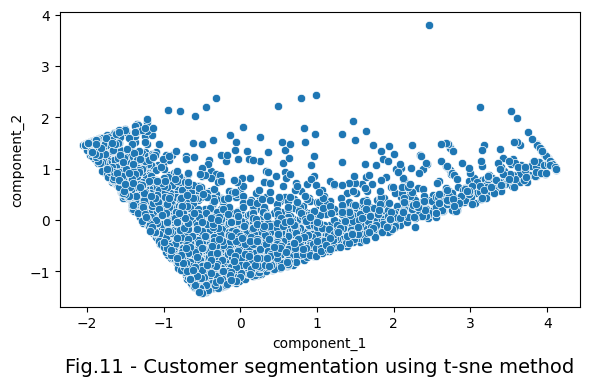

In [329]:

plot_counter = 11
plt.figure(figsize=(6,4))
sns.scatterplot(RFM_processed, x='component_1', y='component_2'); 
plt.title(f'Fig.{plot_counter} - Customer segmentation using t-sne method', y=-0.25, size=14);
plt.tight_layout()

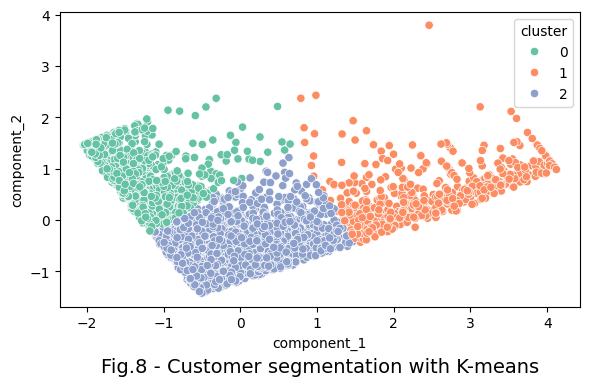

In [331]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10, random_state=random_state)
kmeans.fit(RFM_processed)
#RFM_scaled['cluster'] = kmeans.labels_
RFM_processed['cluster'] = kmeans.labels_
#RFM['cluster'] = kmeans.labels_

plot_counter = 8
plt.figure(figsize=(6,4))
fig = sns.scatterplot(data=RFM_processed, x='component_1', y='component_2', hue='cluster', palette="Set2")#;size=RFM["Monetary value"],sizes=(20, 200)

#fig.set_yscale('log')
fig.set_title(f'Fig.{plot_counter} - Customer segmentation with K-means', y=-0.25, size=14); #for pricipal components of RMF
plt.tight_layout()

In [332]:
RFM_processed['cluster']

0       1
1       2
2       2
3       0
       ..
4325    2
4326    0
4327    1
4328    2
Name: cluster, Length: 4329, dtype: int32

In [292]:
RFM_processed.shape

(4329, 2)

In [293]:
pause=

SyntaxError: invalid syntax (2561474029.py, line 1)

In [334]:
RFM.head()

,Recency,Frequency,Monetary value
12347,41,7,4310.00
12348,77,4,1437.24
12349,20,1,1457.55
12350,312,1,294.40
12352,74,6,1265.41


In [333]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12,2.55,17850,United Kingdom,0.0,15.30,698
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12,3.39,17850,United Kingdom,0.0,20.34,698
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12,2.75,17850,United Kingdom,0.0,22.00,698
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12,3.39,17850,United Kingdom,0.0,20.34,698
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12,3.39,17850,United Kingdom,0.0,20.34,698


In [ ]:
import joblib
pipeline_2_j = joblib.load('../models/pipeline_2.joblib') 
RFM_processed = pipeline_2_j.fit_transform(RFM.copy())
RFM_processed = pd.DataFrame(RFM_processed, columns=['component_1', 'component_2'])
RFM_processed.head()


,component_1,component_2
0,28.932217,-19.938082
1,-8.267018,2.902039
2,-4.778216,-18.807253
3,39.403046,28.855337
4,-9.175975,-14.759377
